# Daniel Perez Efremova y Santiago Queipo de Llano

### Submission Instructions

Just fill in the markdown and code cells below with your arguments and functions, and run the Python lines given. Make sure the notebook works fine by executing `Kernel/Restart & Run All`.
  
Once the notebook is ready,
1. Create a folder named `mbd_last_name1_last_name2` with the team's last names.

2. Put in that folder:

* a file `mp_mbd_last_name1_last_name2.ipynb` with the cells below completed. Make sure it works by executing Kernel/Restart & Run All.
* a file `mp_mbd_last_name1_last_name2.html` with an html rendering of the previous .ipynb file (just apply File / Download as HTML after a correct run of Kernel/Restart & Run All).
* a file `mp_mbd_last_name1_last_name2.pdf` with a pdf print of the html file **without any code**.

3. Compress **the folder** to a `mbd_last_name1_last_name2.7z` 7z (or zip) file.

**Very important!!!**

Make sure you follow the file naming conventions above; the miniproject won't be graded until that is so.

## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

**IMPORTANT AND JUST IN CASE: before turning in your work, please REMOVE FROM IT THE PREVIOUS TWO CELLS**

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Wind Energy Prediction
We want to predict the wind energy production on a farm using wind speed and direction information.

The aim of this wind power forecasting problem is to predict the wind power generation 24 h ahead for a wind farm in Australia.

Attribute Information:
The features include forecasts of the projections of the wind vector on the west-east (U) and south-north (V) axes,at two heights, 10 and 100 m above ground level, plus the corresponding absolute wind speeds.

Data for approximatley a **nine month** period are given in a csv file with headers

`TIMESTAMP,TARGETVAR,U10,V10,U100,V100,v10,v100`

where

* TIMESTAMP contains day/hour information.
* TARGETVAR is the wind energy production normalized to a [0, 100] range.
* U10,V10,U100,V100 are the U and V wind components in m/s at heights 10 and 100.
* v10,v100 are the absolute wind speeds in m/s at heights 10 and 100.

The dataset we will use is an adaptation of those available in the Kaggle page https://www.kaggle.com/c/GEF2012-wind-forecasting. 

**You will observe that the structure and most of the coding is fairly standard.  
Because of this you should focus on streamlining cells and code, avoiding unnecessary elements, and also make a substantial effort on your analysis and conclusions.**

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

In [4]:
def RunCV(cv, param_grid, pipe, X, y):
    cv = GridSearchCV(pipe, 
       param_grid=param_grid, 
       cv=kf, 
       scoring='neg_mean_squared_error',
       n_jobs=-1, 
       verbose=1)

    return cv.fit(X, y)

def CVResultPlot(cv, scoring, kf):

    best_model = cv.best_estimator_

    plt.bar(x=range(9), height=-cross_val_score(best_model, X, y, scoring=scoring, cv=kf, n_jobs=-1))
    plt.title('Cross Validation Result')
    plt.xlabel('Fold Num.')
    plt.ylabel('Mean Squared Error')
    plt.show()
    
def RegressionCVReport(cv, X, y):
    
    best_model = cv.best_estimator_
    error = best_model.predict(X)-y

    plt.figure( figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.scatter(x=best_model.predict(X), y=y)
    plt.plot([0,100], [0,100], c='r')

    plt.subplot(1, 3, 2)
    plt.hist(error)
    
    plt.subplot(1, 3, 3)
    plt.scatter(x=y, y=error)
    plt.plot([0,100], [0,0], c='r')
    
    plt.show()

## Data Loading

We load the csv file using its first column as a `datetime` index.

In [5]:
df_0 = pd.read_csv('w_e.csv', index_col=0, parse_dates=True)
l_vars = df_0.columns[1 : ]
print(l_vars)
df = df_0[l_vars]
df['target'] = df_0['TARGETVAR']

print ("nFilas: %d\tnColumnas: %d\n" % (df.shape[0], df.shape[1]) )
print ("Columnas:\t", np.array(df.columns))

Index(['U10', 'V10', 'U100', 'V100', 'v10', 'v100'], dtype='object')
nFilas: 6576	nColumnas: 7

Columnas:	 ['U10' 'V10' 'U100' 'V100' 'v10' 'v100' 'target']


In [6]:
df.index

DatetimeIndex(['2012-01-01 01:00:00', '2012-01-01 02:00:00',
               '2012-01-01 03:00:00', '2012-01-01 04:00:00',
               '2012-01-01 05:00:00', '2012-01-01 06:00:00',
               '2012-01-01 07:00:00', '2012-01-01 08:00:00',
               '2012-01-01 09:00:00', '2012-01-01 10:00:00',
               ...
               '2012-09-30 15:00:00', '2012-09-30 16:00:00',
               '2012-09-30 17:00:00', '2012-09-30 18:00:00',
               '2012-09-30 19:00:00', '2012-09-30 20:00:00',
               '2012-09-30 21:00:00', '2012-09-30 22:00:00',
               '2012-09-30 23:00:00', '2012-10-01 00:00:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=6576, freq=None)

# Data Exploration, Visualization and Correlations

* Compute descriptive statistics.
* Draw boxplots, pairplots and histograms.
* Compute and present correlations. 

Give your comments and conclusions after each step.

## Descriptive analysis

Comenzamos conociendo primero los datos que se van a trabajar. Mirando las primeras líneas se ve que se tienen 6 variables regresoras y una target. El índice es temporal, por lo que las observaciones pueden tener correlación dependiente del tiempo. Se tiene una observación cada hora durante 6576 instantes para todas las variables. 

In [7]:
df.head()

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013


In [8]:
df.shape

(6576, 7)

Se revisa el tipo de dato y si existen valores perdidos en la serie. Se ve que todas las variables son de tipo decimal y que no existen valores perdidos.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6576 entries, 2012-01-01 01:00:00 to 2012-10-01 00:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   U10     6576 non-null   float64
 1   V10     6576 non-null   float64
 2   U100    6576 non-null   float64
 3   V100    6576 non-null   float64
 4   v10     6576 non-null   float64
 5   v100    6576 non-null   float64
 6   target  6576 non-null   float64
dtypes: float64(7)
memory usage: 411.0 KB


Como primera aproximación a la distribución de las variable se calculan medidas de posición central, como la media y la mediana, y desviación respecto a la media, como la desviación típica. Tambien los cuartiles para ver si hay colas reseñables en las variables.

In [10]:
df.describe()

,U10,V10,U100,V100,v10,v100,target
count,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000,6576.000000
mean,0.925713,-0.248246,1.588242,-0.484932,3.633458,6.327676,30.994200
std,2.554138,2.985638,4.248724,5.126383,1.775482,2.654048,29.565316
min,-7.494252,-9.993858,-10.910809,-15.294866,0.115262,0.075588,0.000000
25%,-1.091453,-2.380193,-1.773337,-4.798816,2.200499,4.432077,5.833568
50%,0.779908,0.010578,1.412786,0.304412,3.325606,6.175986,21.360774
75%,2.483195,1.964029,4.641959,3.614908,4.792335,8.004028,50.155059
max,11.117029,9.066154,16.988418,14.314416,11.743323,18.487084,99.953012


Se observa que las variables U10, U100, v10, v100 y target tienen colas hacia la derecha ya que ni la media ni la mediana estan próximos al punto medio entre mínimo y máximo. Las variables V parecen a priori simétricas, con el mínimo aproximadamente igual al máximo en términos absolutos y con mediana y media cercanas a 0 y con los otros cuartiles igual de alejados en términos absolutos de la mediana. 

Se ve además que la magnitud de la target es muy superior al resto de variables. Es posible que se tengan que utilizar técnicas de regularización para que las variables sean comparables.

Las desviaciones típicas son similares a los cuartiles 1 y 3, por lo que estamos ante conjuntos de valores muy ruidosos alrededor de la media. Ya que un valor se desviará respecto a la media aproximadamente hasta estos cuartiles, valores muy alejados de la media.

Más adelante inspeccionamos visualmente las distribuciones mediante diagramas de cajas o violines, que dan más visión de la distribución completa.

## Boxplots

A través de los diagramas de cajas:

* se confirman las colas hacia la derecha de las variables U10, U100, v10, v100 porque e ve una cantidad significativa de outliers (puntos negros) en la parte superior de las cajas.
* se confirma la simetría de las variables V porque apenas se ven outliers (puntos negros) en las cajas de esas variables.
* se ve que la target toma un rango de valores de una magnitud superior al resto. Se confirma la necesidad de regularizar para poder comparar los valores de las variables.

<AxesSubplot:>

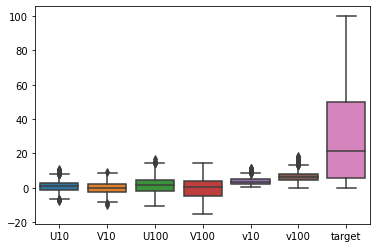

In [11]:
sns.boxplot(data=df)

Con el diagrama de violines se observa además multimodalidad en las variables, algo que se puede estudiar para ver si contiene información útil en relación a la target.

<AxesSubplot:>

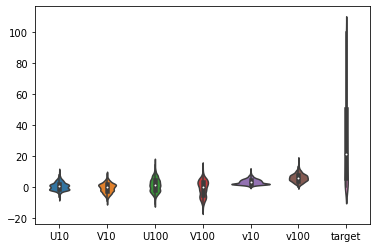

In [12]:
sns.violinplot(data=df)

Se concluyen varios puntos:
* Es necesario regularizar los datos por la diferencia de escalas
* Es necesario aislar los outliers de las variables para estudiarlos a parte
* Es necesario estudiar a qué se debe la multimodalidad de las variables

## Histograms and scatterplots

Ya se han hecho los diagramas de violines y la matriz de diagramas de dispersion los incluyen, asique se obvian los histogramas. Para ver relaciones dos a dos en las variables y estudiar las que tienen relación con la target, se hace una matriz de diagramas de dispersión.

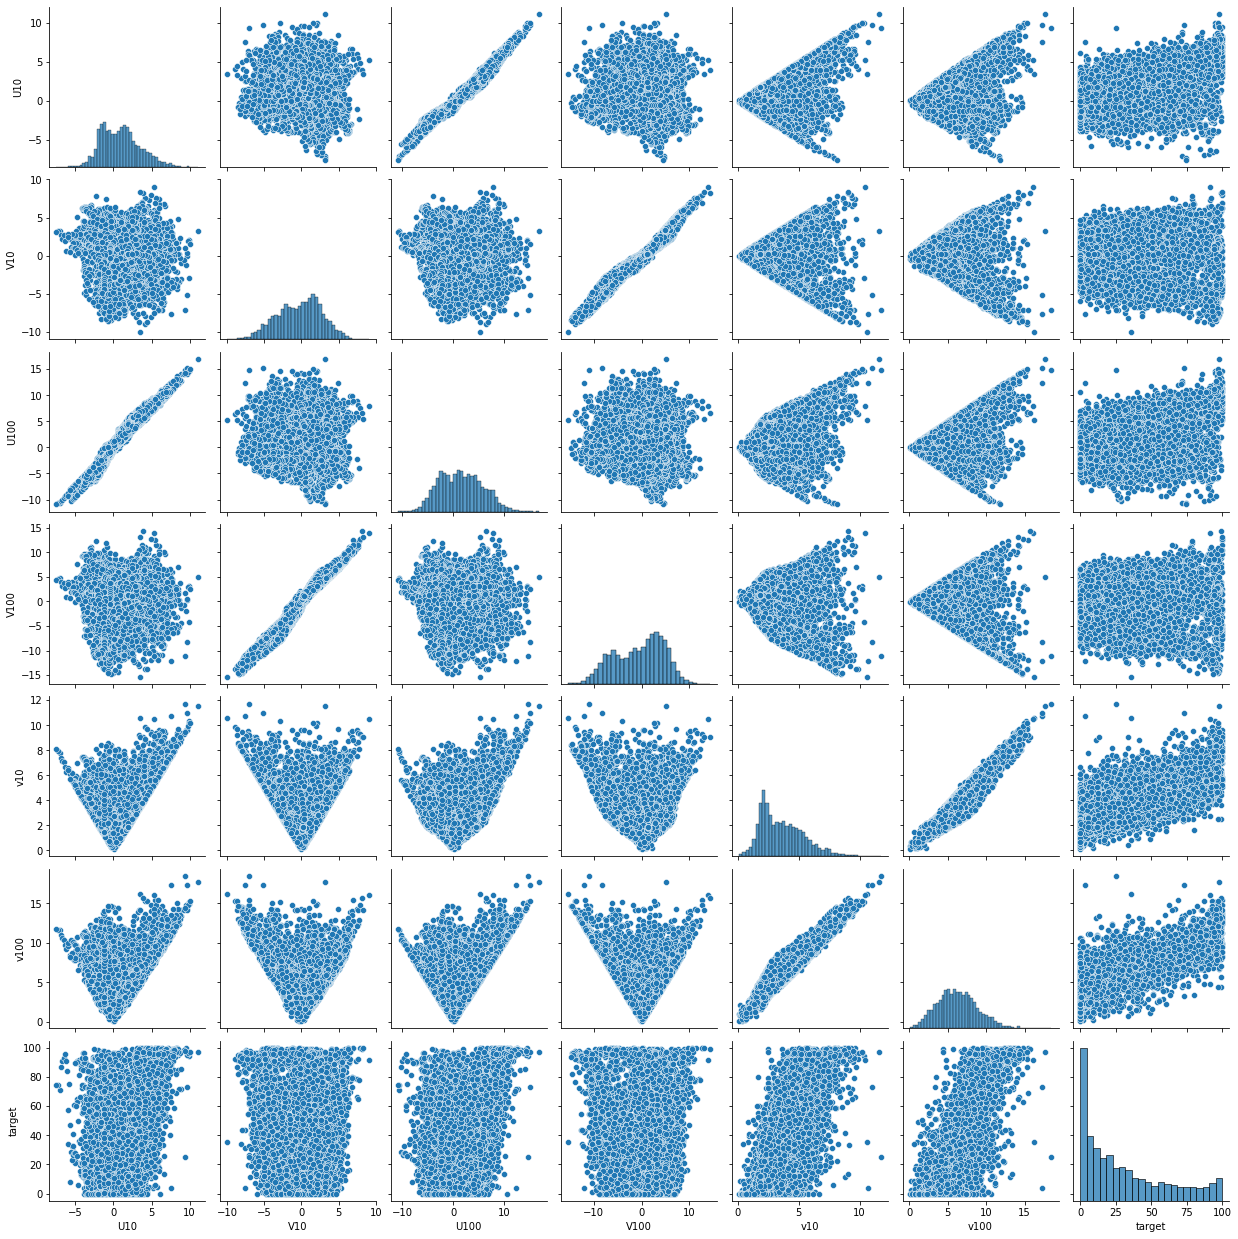

In [13]:
sns.pairplot(data=df)

Se observan varios puntos interesantes:

* Los pares de variables (V10, V100), (v10, v100), (U10, U100) estan fuertemente correlacionados linealmente. Al ser la misma medición de viento a distintas alturas, tiene sentido que esten fuertemente correlacionadas

* Se observa un patrón cónico en los diagramas de las variables v con U y V. Esto se debe a que v es el modulo de las componentes U y V, por lo que el patrón que se está visualizando no nos debe resultar extraño, no es mas que la función valor absoluto (o modulo en el contexto de varias dimensiones). 

* La dispersión de V y U es una bola y no muestran signos de correlación alguna. Se pinta la densidad del diagrama de dispersión para deshechar la hipótesis de correlación.

* En general todas las variables muestran una ligera correlación lineal con la target aunque debido a a la alta variabilidad demostrada en el apartado anterior, la correlación es débil.

Con ánimo de seguir indagando en la bimodalidad vista en los diagramas de violines se pintan algunos diagramas de dispersión junto a la densidad de puntos. Se ve que en las distribuciones conjuntas tal bimodalidad persiste y que está concentrada alrededor de los valores que verifican $U = V$, es decir, el suceso: "El viento tiene las dos componentes de velocidad iguales".

<AxesSubplot:xlabel='V100', ylabel='U100'>

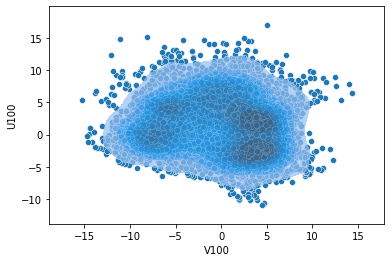

In [14]:
x, y ='V100', 'U100'
sns.scatterplot(data=df, x=x, y=y)
sns.kdeplot(data=df, x=x, y=y, fill=True, alpha=.7)

<AxesSubplot:xlabel='V10', ylabel='U10'>

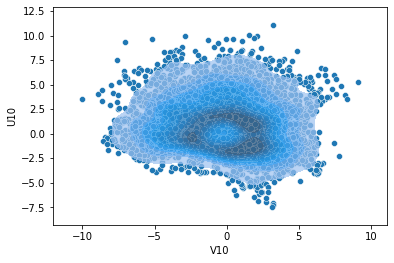

In [15]:
x, y ='V10', 'U10'
sns.scatterplot(data=df, x=x, y=y)
sns.kdeplot(data=df, x=x, y=y, fill=True, alpha=.7)

Se concluye que:
* No debe usarse en regresión la variable modulo $v_i$ con ninguna de las otras variables $U_i, V_i$ ya que $v_i = \sqrt{U_i^2+V_i^2}$ para $i=10$ ó $i=100$. Ya que aparecerán con un coeficiente de correlación relativamente alto para hacer regresión.

* Las variables modulo muestran una correlación más clara con la target que el resto por separado. Por lo que serían buenas candidatas. 

* Las variables U y V no guardan ninguna correlación y pueden usarse conjuntamente para hacer regresión.

* En las curvas de densidad se aprecia que los outliers forman grupos (masking). Lo cual puede tener un efecto tractor en el modelo de regresión (puntos palanca).

## Correlations

Se calcula de manera explícita la matriz de correlaciones (Pearson) para entrar al detalle de las correlaciones vistas anteriormente.

<AxesSubplot:>

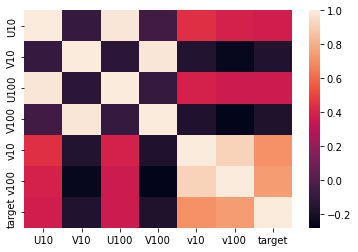

In [16]:
sns.heatmap(df.corr())

Se observan varios puntos:

* Se confirma la correlación lineal alta entre los modulos v y la target
* Se confirma que U y V no guardan ninguna correlación, o al menos lineal.
* Se confirma la correlación de $v_i$ con $U_i$, $V_i$ lo que aumentaría el condicionamiento del problema de regresión si se incluyen juntas.

## Overall conclusions

En general se observa que estamos ante un problema de regresión con variables numéricas. Tienen distinta escala asique es necesario regularizar los datos. Se observan outliers en las distintas variables, lo cual obliga a separlos para no contaminar los metodos de regresion. Se observan variables candidatas como los modulos $v_i$ o los pares $U, V$.

Parece además que podría haber información adicional en la bimodalidad de las distribuciones.

# Ridge Regressor

Perform a CV estimation of a pipelined Ridge regressor over 9 folds over the entire sample **without shuffling**. This way each fold has approximately one month of data.

Se definen las variables, el modelo Ridge y los objetos necesarios para la validación cruzada: la pipeline con el scaler y el modelo, la validación cruzada sin shuffle y el Grid search.

Lo ideal es tener todos los parámetros de configuración en un yaml pero por sencillez se ponen en el código directamente.

El método ridge, por construcción, lleva incluída la selección de variables, por lo que no se hace una selección previa. Será la condición de L2-regularización $\sum \beta_i^2 < \alpha$ la que seleccione las variables.

In [17]:
X, y = df[df.columns.difference(['target'])], df['target']
kf = KFold(n_splits=9)
ridge = Ridge()
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()),
                       ('Ridge', ridge)])
param_grid = {
'Ridge__alpha':[10**k for k in range(-10, 11)]
}

In [18]:
cv = RunCV(kf, param_grid, pipe, X, y)
cv.best_params_, cv.best_score_

Fitting 9 folds for each of 21 candidates, totalling 189 fits


({'Ridge__alpha': 100}, -384.2561324229031)

## Analyzing GridSearchCV results

Check the adequacy of the best hyperparameters.

Ahora se examina el resultado del ajuste del modelo Ridge. Para ello se saca el valor de la metrica de scoring y se compara con el valor del hiperparámetro.

In [19]:
df_cv = pd.DataFrame.from_dict(cv.cv_results_)
result = df_cv.sort_values('rank_test_score')[['param_Ridge__alpha', 'mean_test_score']]
result

,param_Ridge__alpha,mean_test_score
12,100,-384.256132
11,10,-384.262452
10,1,-384.432209
9,0.1,-384.453901
8,0.01,-384.456126
7,0.001,-384.456349
6,0.0001,-384.456371
5,0.00001,-384.456373
4,0.000001,-384.456374
3,0.0,-384.456374


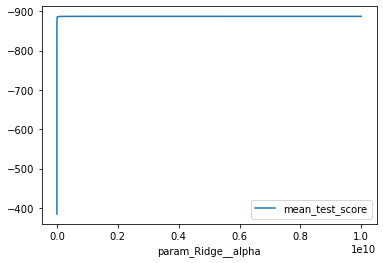

In [20]:
result.plot(kind='line',
             x='param_Ridge__alpha',
             y='mean_test_score').invert_yaxis()
plt.show()

Se ve que el resultado es óptimo para valores entre 0 y 1000. No hay diferencias significativas entre los modelos generados con el hiperparámetro alpha entre ese rango de valores.

## Testing the Ridge model

Do it over the entire dataset using `cross_val_predict`, get the CV MAE and draw the appropriate plots.

En primer lugar se hace un gráfico de barras con las puntuaciones de la validación cruzada del mejor modelo. Se observa que no son muy diferentes entre ellas, lo que puede indicar que el modelo no generalizaría bien, siendo dependiente del conjunto de entrenamiento.

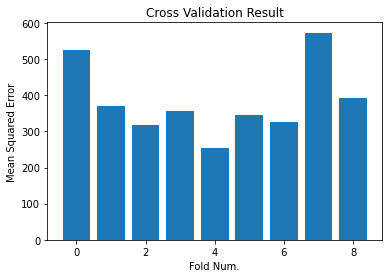

In [21]:
CVResultPlot(cv, scoring='neg_mean_squared_error', kf=kf)

Para terminar de diagnosticar el modelo, se realizan 3 gráficos comunes en regresión:

* Predicción del modelo frente al valor real comparado con la recta identidad $y=x$. Si el modelo es correcto y preciso en sus estimaciones, se debe observar que la nube de puntos esta muy cerca de la recta identidad.

* Histograma de los errores. Se utiliza para comprobar si los residuos siguen una distribución aleatoria, por lo general normal. 

* Valor error frente al error de predicción. Si el modelo está correctamente especificado, se debería observar una línea totalmente horizontal (independencia de los errores) y con la misma variabilidad a lo largo de toda la recta horizontal (homocedasticidad del error). 

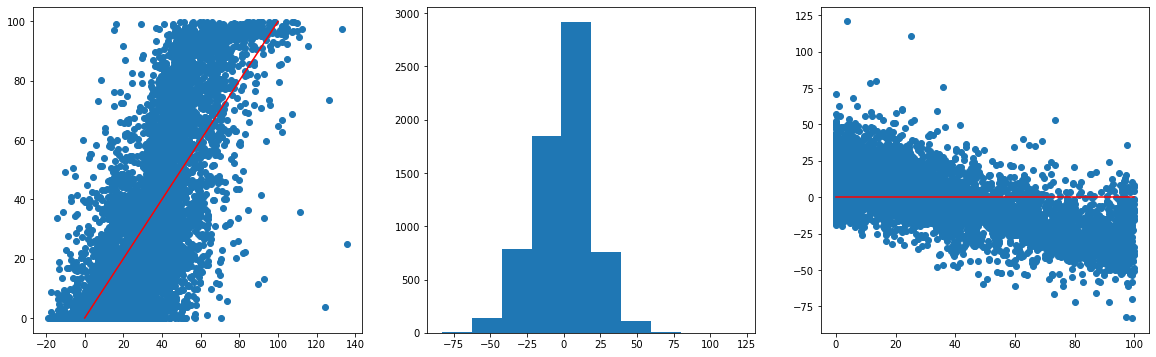

In [22]:
RegressionCVReport(cv, X, y)

* En el primer gráfico se observa que las predicciones estan subestimando el valor real para valores grandes de $y$ y sobreestimando para valores pequeños.

* En el segundo se aprecian signos de normalidad que deben comprobarse con un test de normalidad. En la celda de abajo, tanto el test de Shapiro como el de Kolmogorov-Smirnov dan un pvalor cercanos a cero, por lo que no hay evidencia estadística de normalidad.

* En el tercer gráfico se aprecia que no hay heterocedasticidad en los residuos y, de hecho, se ve un patron lineal descendente. Puede ser signo de variables ocultas.

## Ridge Residual histograms and relationship with targets

Show and discuss them.

Respondido arriba

## Conclusions on the base Ridge model

A modo de conclusión despues de encontrar y ajustar el mejor modelo Ridge, la evidencia apunta a que los datos contienen una varianza excesivamente alta como para ser tratado con un modelo lineal. Además hay outliers en grupos, lo que dificulta llegar a conclusiones claras. En posible que con la función de perdida de Huber se pudiese mitigar el efecto de los grupos de outlier. Esta función de pérdida modifica el error cuadrático a uno lineal si se supera una cota de error en la estimación. La cota se debe estimar por validación cruzada.

Además el método Ridge no elimina variables. Es posible que aplicando el método LAR (Least Angle Regression) por el método LASSO se lograsen mejores resultados aunque requiere inspeccionar visualmente el camino y elegir el corte que da las variables deseadas.

# Trying to improve the estimator

Me may try to improve the Ridge results in two different ways:
* first, by enlarging the features set with the **square and cube powers of the absolute velocities** and reapplying a Ridge model.
* second, by using these enlarged features but working with another model, the HuberRegressor (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html), using its default parameters and hyperparametrizing the `alpha` hyperparameter.

Redo the previous Ridge MLPR analysis and conclusions over the enlarged dataset with the same analysis structure previously used.

# Ridge modeling over enlarged features

Aplicamos un aumento de variables elevando al cuadrado las velocidades absolutas.

Index(['U10', 'V10', 'U100', 'V100', 'v10', 'v100', 'target', 'v10_squared',
       'v100_squared'],
      dtype='object')

In [41]:
df[['v10_squared', 'v100_squared']] = df[['v10', 'v100']]**2
df['U_V_10'], df['U_V_100'] = df['U10']-df['U100'], df['V10']-df['V100']
X, y = df[df.columns.difference(['target'])], df['target']

## Conclusions on the enlarged Ridge model

In [24]:
cv = RunCV(kf, param_grid, pipe, X, y)
cv.best_params_, cv.best_score_

Fitting 9 folds for each of 21 candidates, totalling 189 fits


({'Ridge__alpha': 1}, -373.36026493572797)

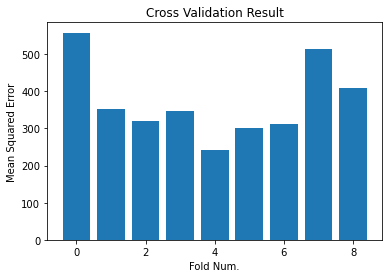

In [25]:
CVResultPlot(cv, scoring='neg_mean_squared_error', kf=kf)

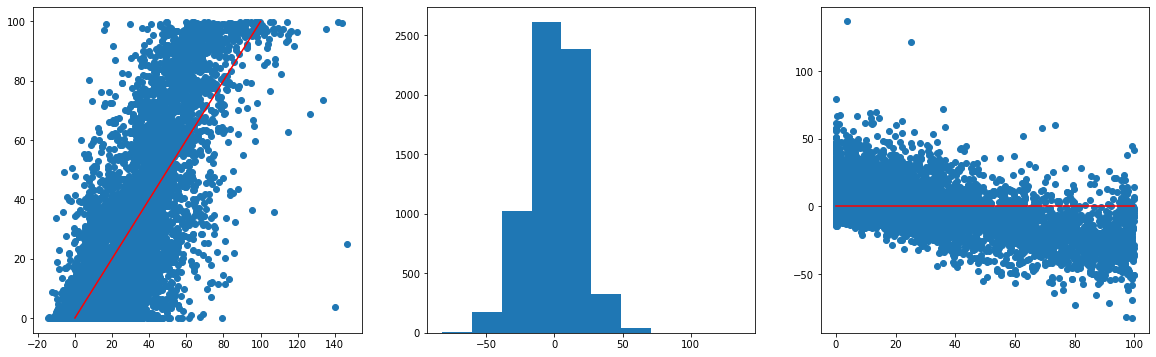

In [26]:
RegressionCVReport(cv, X, y)

# Huber Regression  modeling over enlarged features

Apply a `HuberRegressor` model to the enlarged data and search for the optimal hyperparameter `alpha`.  

Its scikit-learn API is at 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor

In [42]:
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()),
                       ('Huber', HuberRegressor())])
param_grid = {
'Huber__epsilon':np.arange(1,100,1),
'Huber__fit_intercept': [True, False]
}

In [43]:
cv = RunCV(kf, param_grid, pipe, X, y)
cv.best_params_, cv.best_score_

Fitting 9 folds for each of 198 candidates, totalling 1782 fits


({'Huber__epsilon': 4, 'Huber__fit_intercept': True}, -373.37732394138516)

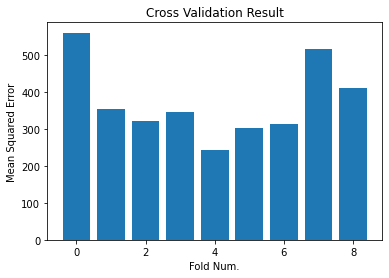

In [44]:
CVResultPlot(cv, scoring='neg_mean_squared_error', kf=kf)

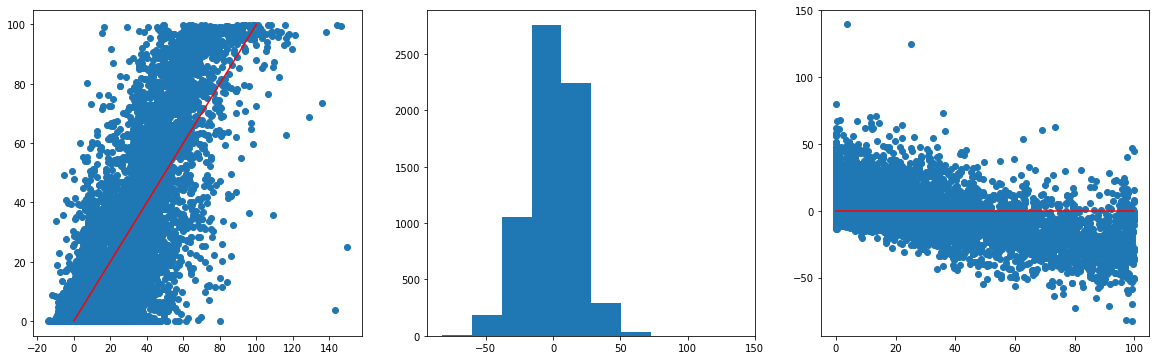

In [45]:
RegressionCVReport(cv, X, y)

## Conclusions on the enlarged Huber model

El modelo con las nuevas variables no ofrece resultados distintos a los anteriores. La idea de que existen variables que no se estan tomando se refuerza.

# Final conclusions

En esta práctica se han ajustado los tres modelos Ridge, Huber y ambos dos enriquecidos operando las variables. En todos los casos llevan a resultados que demuestran la existencia de variables ocultas que no se estan considerando. Pese a que el regresor de Huber mitiga el efecto de outliers no ofrece una mejora sustancial al metodo Ridge. 

Dado el caracter temporal de las observaciones, es posible que se puede extraer información de valor de las horas o días de la semana para completar las variables. 